### Preamble
Please consult the previous examples for the basics how to run a simulation, understanding of how to prepare correctly the directivity of a source, how to prepare a focusing source and prepare mixed (water-solid) simumlation domain

### IMPORTANT - extra Python libraries , suggestion to use Python 3.5 to  3.7 and Linux
This notebook uses two extra packages, `pyvista` and `pymesh`. `pyvista` is easy to install via `pip install pyvista` as it is widely available for pretty much for all recent Python versions and OSs. For `pymesh` installation, consult https://github.com/PyMesh/PyMesh.
#  Tilted solid surrounded by water

This time we simulate the case a block of plastic (1.4 cm-thick) surrounded by water and rotate 20 degrees. We will identify some of the issues associated to staircase artifacts for wtaer-solid boundaries  not aligned to the Cartesian grid. These artifacts can be removed by increasing significantly the resolution, but it entails a high computational costs and memory requirements that quickly may not be satisfied for large domains, as main GPU memory remains always much more limited that main CPU memory.

## Use of superposition method to address staircase artifacts

We will present how to use the **superposition method** as an alternative that has less memory requirements to improve the precision of simulations.

    Drainville, R.A., Curiel, L. and Pichardo, S., 2019. Superposition method for modelling boundaries between media in viscoelastic finite difference time domain simulations. The Journal of the Acoustical Society of America, 146(6), pp.4382-4401. https://asa.scitation.org/doi/abs/10.1121/1.5139221

It is highly recommended you read the paper to cover the basics of the method.

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from BabelViscoFDTD.H5pySimple import ReadFromH5py,SaveToH5py
from BabelViscoFDTD.PropagationModel import PropagationModel
from scipy import ndimage
from skimage.draw import circle_perimeter,disk, polygon, polygon2mask
from skimage.transform import rotate
from ipywidgets import  HBox, VBox, GridBox, Layout, Label, IntSlider, interact,\
    Checkbox,GridspecLayout,interactive, widgets, FloatSlider
from IPython.display import display,clear_output


PModel=PropagationModel()
bUseTrimesh=False
if bUseTrimesh:
    import trimesh
    import pyvista as pv
    import pyvistaqt as pvqt

Domain size 127 55 198


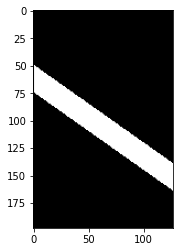

In [20]:
Frequency = 350e3  # Hz
WaterSOS = 1500 # m/s - water
WaterDensity=1000 # kg/m3

#Acryic
SolidLSOS = 2848 # m/s - 
SolidsSOS = 1026 # m/s - 
SolidDensity=1190 # kg/m3
SolidLAlpha = 0# Np/m we test with no attenuation to better illustrate the effects of staircasing
SolidSAlpha= 0# Np/m 

ShortestWavelength =SolidsSOS / Frequency
SpatialStep =ShortestWavelength / 6.0 # A minimal step of 6 is recommnded

DimDomain =  np.array([0.05,0.015,0.085])  # in m, x,y,z  # in m, x,y,z

TxDiameter=0.01
PMLThickness = 12 # grid points for perect matching layer, HIGHLY RECOMMENDED DO NOT CHANGE THIS SIZE 
ReflectionLimit= 1.0000e-05 #reflection parameter for PML, HIGHLY RECOMMENDED DO NOT CHANGE THIS VALUE

N1=int(np.ceil(DimDomain[0]/SpatialStep)+2*PMLThickness)
N2=int(np.ceil(DimDomain[1]/SpatialStep)+2*PMLThickness)
N3=int(np.ceil(DimDomain[2]/SpatialStep)+2*PMLThickness)
print('Domain size',N1,N2,N3)
TimeSimulation=np.sqrt(DimDomain[0]**2+DimDomain[1]**2+DimDomain[2]**2)/(np.mean([SolidsSOS,WaterSOS]))*2/3 #time to cross one corner to another
TemporalStep=5e-8 # if this step is too coarse a warning will be generated (but simulation will continue,) 

MaterialMap=np.zeros((N1,N2,N3),np.uint32) # note the 32 bit size
MaterialList=np.zeros((2,5)) # two materials in this example
MaterialList[0,0]=WaterDensity # water density
MaterialList[0,1]=WaterSOS # water SoS

MaterialList[1,0]=SolidDensity # plastic density
MaterialList[1,1]=SolidLSOS # plastic long. SoS
MaterialList[1,2]=SolidsSOS # plastic shear SoS
MaterialList[1,3]=SolidLAlpha # plastic long. attenuation
MaterialList[1,4]=SolidSAlpha # plastic shear attenuation

#we define two - half spaces

BT=-50
Thick=25
AngleInterface=np.deg2rad(45)
m=np.sin(AngleInterface)
NY3=(N1-1)*m
r0=np.array([(N3/2)+BT,(N3/2)+BT+NY3,(N3/2)+NY3+BT+Thick, (N3/2)+BT+Thick])+0.5

p0=np.array([0.5,N1-0.5,N1-0.5,0.5])
rrcc=polygon(p0,r0)
mm=polygon2mask((N1,N3),np.vstack((p0,r0)).T)

MaterialMap[:,:,:]=np.tile(np.reshape(mm,[N1,1,N3]),[1,N2,1])

plt.figure()
plt.imshow(MaterialMap[:,int(N2/2),:].T,cmap=plt.cm.gray);

COMPUTING_BACKEND=2
DefaultGPUDeviceName='M1'
#all other parameters are set to 0 


In this example, we will use a small source placed close to the solid material to produce a tight beam crossing the solid,

We use a rotated focusing source so we can analyze the multiple stress that are generated once the acoustic beam reaches the solid. This time we show both source and layered material to verify the source does not overlap.

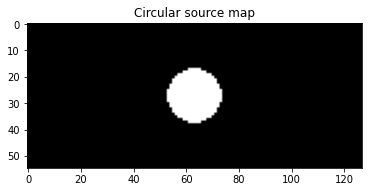

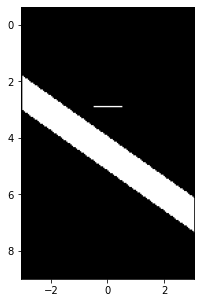

In [4]:
def MakeCircularSource(DimX,DimY,SpatialStep,Diameter):
    #simple defintion of a circular source centred in the domain
    XDim=np.arange(DimX)*SpatialStep
    YDim=np.arange(DimY)*SpatialStep
    XDim-=XDim.mean()
    YDim-=YDim.mean()
    XX,YY=np.meshgrid(XDim,YDim)
    MaskSource=(XX**2+YY**2)<=(Diameter/2.0)**2
    return (MaskSource*1.0).astype(np.uint32)

plt.figure()
SourceMask=MakeCircularSource(N1,N2,SpatialStep,TxDiameter)
plt.imshow(SourceMask,cmap=plt.cm.gray);
plt.title('Circular source map')

SourceMap=np.zeros((N1,N2,N3),np.uint32)
LocZ=PMLThickness+60
SourceMap[:,:,LocZ]=SourceMask.T 

Ox=np.zeros((N1,N2,N3))
Oy=np.zeros((N1,N2,N3))
Oz=np.zeros((N1,N2,N3))
Oz[SourceMap>0]=1 #only Z has a value of 1

XDim=(np.arange(N1)*SpatialStep-(PMLThickness+1)*SpatialStep)*100 #cm
XDim-=XDim.mean()
ZDim=(np.arange(N3)*SpatialStep-(PMLThickness+1)*SpatialStep)*100 #cm
plt.figure(figsize=(6,5))
plt.imshow(SourceMap[:,int(N2/2),:].T+MaterialMap[:,int(N2/2),:].T,cmap=plt.cm.gray,extent=[XDim.min(),XDim.max(),ZDim.max(),ZDim.min()]);

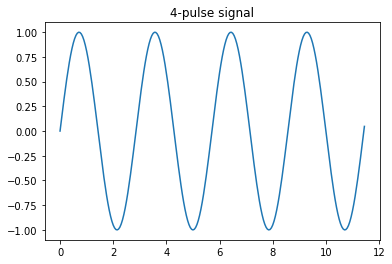

In [5]:
LengthSource=4.0/Frequency #we will use 4 pulses
TimeVectorSource=np.arange(0,LengthSource+TemporalStep,TemporalStep)

PulseSource = np.sin(2*np.pi*Frequency*TimeVectorSource)
plt.figure()
plt.plot(TimeVectorSource*1e6,PulseSource)
plt.title('4-pulse signal')

#note we need expressively to arrange the data in a 2D array
PulseSource=np.reshape(PulseSource,(1,len(TimeVectorSource))) 

In [6]:
SensorMap=np.zeros((N1,N2,N3),np.uint32)

SensorMap[PMLThickness:-PMLThickness,int(N2/2),PMLThickness:-PMLThickness]=1

### Uncorrected calculation
We calculate firs using the standard FDTD approach, where the staircase effect appears

In [7]:
Sensor,LastMap,DictRMSValue,InputParam=PModel.StaggeredFDTD_3D_with_relaxation(
                                                         MaterialMap,
                                                         MaterialList,
                                                         Frequency,
                                                         SourceMap,
                                                         PulseSource,
                                                         SpatialStep,
                                                         TimeSimulation,
                                                         SensorMap,
                                                         Ox=Ox,
                                                         Oy=Oy,
                                                         Oz=Oz,
                                                         NDelta=PMLThickness,
                                                         ReflectionLimit=ReflectionLimit,
                                                         COMPUTING_BACKEND=COMPUTING_BACKEND,
                                                         SelRMSorPeak=2,
                                                         USE_SINGLE=True,
                                                         SelMapsRMSPeakList=['ALLV','Sigmaxx',
                                                                            'Sigmayy','Sigmazz',
                                                                            'Sigmaxy','Sigmaxz',
                                                                            'Sigmayz','Pressure'],
                                                         DefaultGPUDeviceName=DefaultGPUDeviceName,
                                                         SelMapsSensorsList=['Vx','Vy','Vz','Sigmaxx',
                                                                            'Sigmayy','Sigmazz',
                                                                            'Sigmaxy','Sigmaxz',
                                                                            'Sigmayz','Pressure'],
                                                         SensorSubSampling=4,
                                                         TypeSource=0,
                                                         SILENT=1)

VLongInput,VShearInput [1500. 2848.] [   0. 1026.]
Q_cw_factor_long,Q_cw_factor_shear [1.] [1.]
VLongMat,VShearMat [1500. 2848.] [   0. 1026.]
dt,VLongMat,VShearMat,TauLong,TauShear,TauSigma,VLongInput,VShearInput 8.404576966674366e-08 [1500. 2848.] [   0. 1026.] [0.] [0.] [4.54728409e-07] [1500. 2848.] [   0. 1026.]
Matrix size= 127 x 55 x 198 , spatial resolution = 0.000488571, time steps = 627, temporal step = 8.40458e-08, total sonication length 5.26522e-05 
Performing Simulation with GPU OPENCL
Device  M1  Found!
Address bits 64
Number Selected Sensor Maps: 8
Allocating for LambdaMiuMatOverH 2 elements
Allocating for LambdaMatOverH 2 elements
Allocating for MiuMatOverH 2 elements
Allocating for TauLong 2 elements
Allocating for OneOverTauSigma 2 elements
Allocating for TauShear 2 elements
Allocating for InvRhoMatH 2 elements
Allocating for Ox 1383030 elements
Allocating for Oy 1383030 elements
Allocating for Oz 1383030 elements
Allocating for SourceFunctions 230 elements
Allocatin

### Ploting data

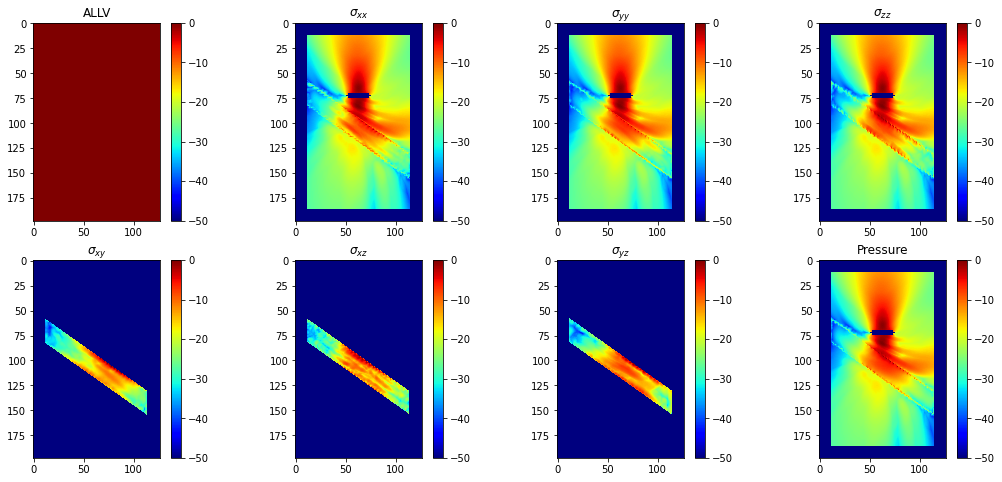

In [8]:
plt.figure(figsize=(18,8))
n=1
for k,RMSValue in DictRMSValue.items():
    for a in range(3):
        for m in range(-2,3):
            RMSValue[np.roll(SourceMap>0,m,axis=a)]=0. #we turn off the values close the source 
    plt.subplot(2,4,n)
    selP=RMSValue[:,int(N2/2),:].copy()
    if 'Sigma' in k:
        selP=selP/1e5 
    selP[selP==0]=1e-6;
    selP=20*np.log10(selP/selP.max())
    plt.imshow(selP.T,cmap=plt.cm.jet,vmin=-50)
    plt.colorbar()
    if 'Sigma' in k:
        plt.title('$\sigma_{'+k.split('Sigma')[1]+'}$')
    else:
        plt.title(k)
    n+=1


### Plot sensor data maps over time
As we collected sensor data for $V_x$, $V_y$, $V_y$, $\sigma_{xx}$, $\sigma_{yy}$, $\sigma_{zz}$, $\sigma_{xy}$, $\sigma_{xz}$, and $\sigma_{xz}$ , we can plot them using a widget to scroll the data over time

In [9]:
class ShowTimeData(object):
    def __init__(self,N1,N2,N3,InputParam,SourceMap,Sensor,Skip=1):
        nL=Sensor['Vx'].shape[1]
        IndTime=np.arange(0,nL,Skip)
        SensorPlane={}
        for k in Sensor:
            if k=='time':
                continue
            SensorPlane[k]=np.zeros((N1,N3,len(IndTime)))
        BInd=[]
        for n, index in enumerate( InputParam['IndexSensorMap']): 
            k=int(index/(N1*N2))
            j=int(index%(N1*N2))
            i=int(j%N1)
            j=int(j/N1)
            BInd.append([i,j,k])
        BInd=np.array(BInd)
        for k in SensorPlane:
            for nt,et in enumerate(IndTime):
                SensorPlane[k][BInd[:,0],BInd[:,2],nt]=Sensor[k][:,et]
            if 'Sigma' in k:
                SensorPlane[k]/=1e5
        self.SensorPlane=SensorPlane
        self.fig=None
        
    def PlotTimePoint(self,timep=0):
        if self.fig:
            plt.close(self.fig)
        
        self.fig=plt.figure(figsize=(16,16))
        n=1
        for k in  self.SensorPlane:
            plt.subplot(4,3,n)
            plt.imshow(self.SensorPlane[k][:,:,timep].T,cmap=plt.cm.jet)
            plt.colorbar()
            n+=1
            if 'V' in k:
                plt.title('$V_'+k.split('V')[1]+'$')
            elif 'Sigma' in k:
                plt.title('$\sigma_{'+k.split('Sigma')[1]+'}$')
            else:
                plt.title(k)
        plt.show()
        
    def SelectTimePoint(self):
        Sel=IntSlider(description='Time point',value=0,
                        min=0,max=self.SensorPlane[list(self.SensorPlane.keys())[0]].shape[2]-1,step=1,continuous_update=False,
                        layout=Layout(width='75%'),style={'description_width': 'initial'})
        interact(self.PlotTimePoint,timep=Sel)
       
        

In [10]:
ShowTimeData(N1,N2,N3,InputParam,SourceMap,Sensor).SelectTimePoint()

interactive(children=(IntSlider(value=0, continuous_update=False, description='Time point', layout=Layout(widt…

Because the orientation of the transducer rotated along the $Y$ axis, we can clearly see the P-wave (faster and with longer wavelength) in $\sigma_{xx}$ and $\sigma_{zz}$, and the S-wave (slower and with shorter wavelength) in $\sigma_{xy}$, $\sigma_{xz}$, $\sigma_{yz}$

# Superposition method

In practice, the superposition method consist in combining multiple simulation at low-resolution where each simulation uses a water-solid domain that depends on the level of intersection of the ideal plane representing the water-solid interface.

In our example we can plot the *ideal* boundary between the water-solid media.

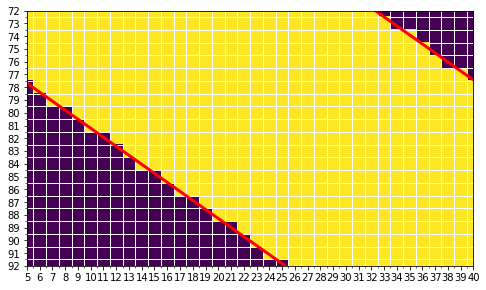

In [11]:
plt.figure(figsize=(8,6))
plt.imshow(MaterialMap[:,int(N2/2),:].T);
plt.plot(p0,r0,'r',linewidth=3)
ax = plt.gca();
ax.set_xticks(np.arange(0, N1, 1));ax.set_yticks(np.arange(0, N3, 1))
ax.set_xticks(np.arange(-.5, N1, 1), minor=True);ax.set_yticks(np.arange(-.5, N3, 1), minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=1)
plt.ylim(92,72);plt.xlim(5,40);ax.set_aspect(1)


We can see that voxels that are roughly 50% or more below the line (<span style="color:red">red</span>) of interface are considered solid (<span style="color:yellow;background-color:black">yellow</span>) while if less of 50% are considered water (<span style="color:purple">purple</span>). However, a more appropriate approach would be to consider the real fraction of solid of voxel inside the region defined as solid.

The superposition method solves this problem by running `N` simulations where voxels are classified either solid or water using the following pseudocode
```
for n=1 to N
    for all voxels
        if G(voxel) < n/N
            voxel is consider solid
        else
            voxel is considered water
```
where `G` is the fraction of the voxel inside the region considered as solid. If we run `N=10` simulations, a voxel that has a fraction around 0.3 will be included 3 times as solid (and 7 as water), while a voxel that has a fraction 0.7 will be included 7 times as solid (and 3 as water), and so on. The final result of the simulation is the average of the temporal signals of the `N` simulations.

### Use of constructive solid geometry (CSG) to calculate solid fraction of `G` of voxels

We will use CSG to calculate the fraction `G`. First, we use simply morphological operations to find the voxels that surround the boundary line.

/var/folders/5s/12dkrmtj48df4qxdb694k5g00000gn/T/ipykernel_22476/3134829193.py:2: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  SolidRing=np.logical_xor(ndimage.morphology.binary_dilation(SolidRegion),ndimage.morphology.binary_erosion(SolidRegion))
/var/folders/5s/12dkrmtj48df4qxdb694k5g00000gn/T/ipykernel_22476/3134829193.py:2: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  SolidRing=np.logical_xor(ndimage.morphology.binary_dilation(SolidRegion),ndimage.morphology.binary_erosion(SolidRegion))


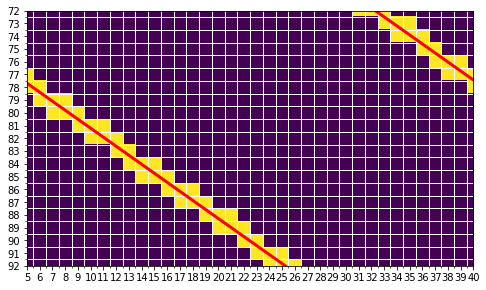

In [12]:
SolidRegion=MaterialMap!=0
SolidRing=np.logical_xor(ndimage.morphology.binary_dilation(SolidRegion),ndimage.morphology.binary_erosion(SolidRegion))

plt.figure(figsize=(8,6))
plt.imshow(SolidRing[:,int(N2/2),:].T*5);
plt.plot(p0,r0,'r',linewidth=3)
ax = plt.gca();
ax.set_xticks(np.arange(0, N1, 1));ax.set_yticks(np.arange(0, N3, 1))
ax.set_xticks(np.arange(-.5, N1, 1), minor=True);ax.set_yticks(np.arange(-.5, N3, 1), minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=1)
plt.ylim(92,72);plt.xlim(5,40);ax.set_aspect(1)


As the solid layer is relatively simple, we can use a delaunay operation to build a 3D object. We can use the interactive visualization tools from `pyvistaqt` to inspect the solid object.

In [12]:
if bUseTrimesh::
    iring,jring,kring=np.where(SolidRing)
    SolidVertices=np.vstack((np.vstack((p0,np.ones(4)*0.5,r0)).T,np.vstack((p0,np.ones(4)*N2-0.5,r0)).T))
    cloud = pv.PolyData(SolidVertices)
    meshSolid = cloud.delaunay_3d().extract_surface()
    tetSolid = pymesh.form_mesh(meshSolid.points,meshSolid.faces.reshape(-1, 4)[:, 1:]);
    pla=pv.PlotterITK()
    pla.add_mesh(meshSolid)
    pla.show(True)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

### CSG boolean intersection
The CSG operation is computionally intense, it takes a few minutes to complete. We can use the libray `pymp` to run the task in parallel, but still it will take some time. Even if this may look as a detriment, it still remains that other techniques or libraries can be explored to calculate this step. Also, for many FDTD simulations, this step will need to be run only once or very few times depending on the conditions.

Also, for simple cases like this, you can use 2D CSG operations (also available in `pymesh`) that are much faster. The purpose to use a 3D CSG operation is to provide a framework for users that can adapt for their needs.

For simplicity purposes, we are going to load a precalculate result. 

In [13]:
bRecalculate=False
if bRecalculate:
    import pymp
    GMap=(MaterialMap>0)*1.0
    GResults = pymp.shared.array((iring.shape[0]))
    with pymp.Parallel(4) as p:
        for n in p.range(0, iring.shape[0]):

            i=iring[n]
            j=jring[n]
            k=kring[n]
            im=i-0.5
            ip=i+0.5
            jm=j-0.5
            jp=j+0.5
            km=k-0.5
            kp=k+0.5
            pp=np.zeros((8,3))
            pp[0,:]=[im,jm,km]
            pp[1,:]=[ip,jm,km]
            pp[2,:]=[ip,jp,km]
            pp[3,:]=[im,jp,km]
            pp[4,:]=[im,jm,kp]
            pp[5,:]=[ip,jm,kp]
            pp[6,:]=[ip,jp,kp]
            pp[7,:]=[im,jp,kp]

            cloudC = pv.PolyData(pp)
            meshCube = cloudC.delaunay_3d().extract_surface()

            tetCube = pymesh.form_mesh(meshCube.points,meshCube.faces.reshape(-1, 4)[:, 1:]);
            res=pymesh.boolean(tetCube, tetSolid,"intersection",engine="igl").volume
            with p.lock:
                GResults[n] =res
            if (n%5000==0):
                p.print(n,len(iring))
        
    for i,j,k,n in zip(iring,jring,kring,range(iring.shape[0])):
            GMap[i,j,k]=GResults[n]       
            
    np.savez_compressed('GMAPSolid',GMap=GMap)
else:
    GMap=np.load('GMAPSolid.npz')['GMap']


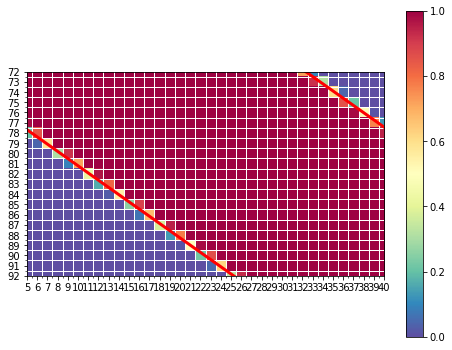

In [14]:
plt.figure(figsize=(8,6))
plt.imshow(GMap[:,int(N2/2),:].T,cmap=plt.cm.Spectral_r);
plt.plot(p0,r0,'r',linewidth=3)
ax = plt.gca();
ax.set_xticks(np.arange(0, N1, 1));ax.set_yticks(np.arange(0, N3, 1))
ax.set_xticks(np.arange(-.5, N1, 1), minor=True);ax.set_yticks(np.arange(-.5, N3, 1), minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=1)
plt.ylim(92,72);plt.xlim(5,40);ax.set_aspect(1)
plt.colorbar();

We can see how the CSG operation did an accurate result to produce the fraction of each voxel being intersected by the ideal water-solid boundary.

---


##  Method 1 - run superposition directly in GPU
To enable the superposition module, specify a value larger than 1 to the optional parameter `SPP_ZONES` (which has a default value of 1), and provide the matrix of solid fraction through the parameter `SPP_VolumeFraction`.

This approach will use `SPP_ZONES` copies of the simulation arrays during the whole execution. The advantage is that the RMS values can be calculated for the whole 3D domain. The limitation is obvioulsy the extra memory requirements to keep at the same time.

In [21]:
SensorSPP,LastMapSPP,DictRMSValueSPP,InputParam=PModel.StaggeredFDTD_3D_with_relaxation(
                                                         MaterialMap,
                                                         MaterialList,
                                                         Frequency,
                                                         SourceMap,
                                                         PulseSource,
                                                         SpatialStep,
                                                         TimeSimulation,
                                                         SensorMap,
                                                         Ox=Ox,
                                                         Oy=Oy,
                                                         Oz=Oz,
                                                         NDelta=PMLThickness,
                                                         ReflectionLimit=ReflectionLimit,
                                                         COMPUTING_BACKEND=COMPUTING_BACKEND,
                                                         USE_SINGLE=True,
                                                         SelRMSorPeak=2,
                                                         DT=TemporalStep,
                                                         SelMapsRMSPeakList=['ALLV','Sigmaxx',
                                                                            'Sigmayy','Sigmazz',
                                                                            'Sigmaxy','Sigmaxz',
                                                                            'Sigmayz','Pressure'],
                                                         DefaultGPUDeviceName=DefaultGPUDeviceName,
                                                         SelMapsSensorsList=['Vx','Vy','Vz',
                                                                            'Sigmaxx',
                                                                            'Sigmayy','Sigmazz',
                                                                            'Sigmaxy','Sigmaxz',
                                                                            'Sigmayz','Pressure'],
                                                         SensorSubSampling=4,
                                                         TypeSource=0,
                                                         SPP_ZONES=20, # we add these extra parameters
                                                         SPP_VolumeFraction=GMap, 
                                                         SILENT=1)

VLongInput,VShearInput [1500. 2848.] [   0. 1026.]
Q_cw_factor_long,Q_cw_factor_shear [1.] [1.]
VLongMat,VShearMat [1500. 2848.] [   0. 1026.]
dt,VLongMat,VShearMat,TauLong,TauShear,TauSigma,VLongInput,VShearInput 8.404576966674366e-08 [1500. 2848.] [   0. 1026.] [0.] [0.] [4.54728409e-07] [1500. 2848.] [   0. 1026.]
The specified manual step  is smaller than the minimal optimal size, calculations may take longer than required
 5e-08 8.404576966674366e-08
We will use SPP
No isolated voxels were found
No isolated voxels were found
No isolated voxels were found
No isolated voxels were found
No isolated voxels were found
No isolated voxels were found
No isolated voxels were found
No isolated voxels were found
No isolated voxels were found
No isolated voxels were found
No isolated voxels were found
No isolated voxels were found
No isolated voxels were found
No isolated voxels were found
No isolated voxels were found
No isolated voxels were found
No isolated voxels were found
No isolated vo

### Ploting data

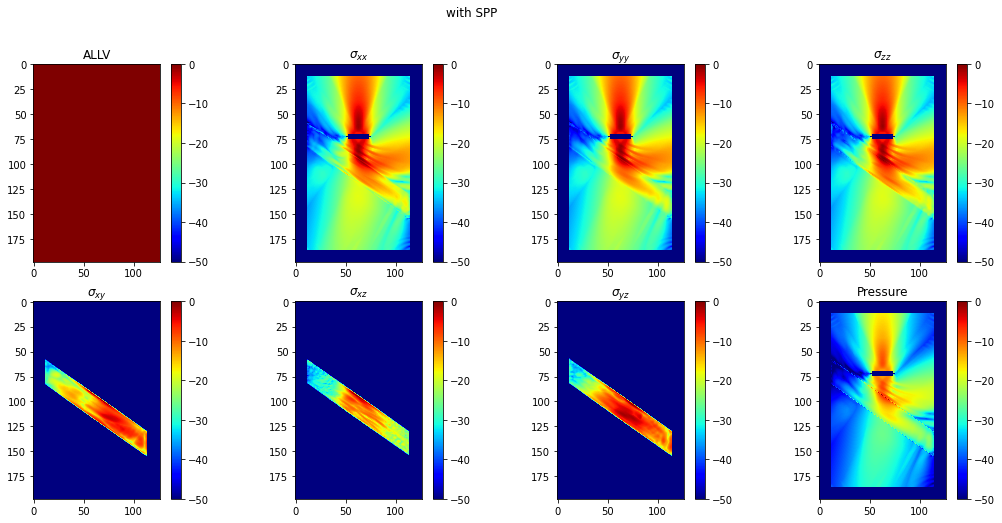

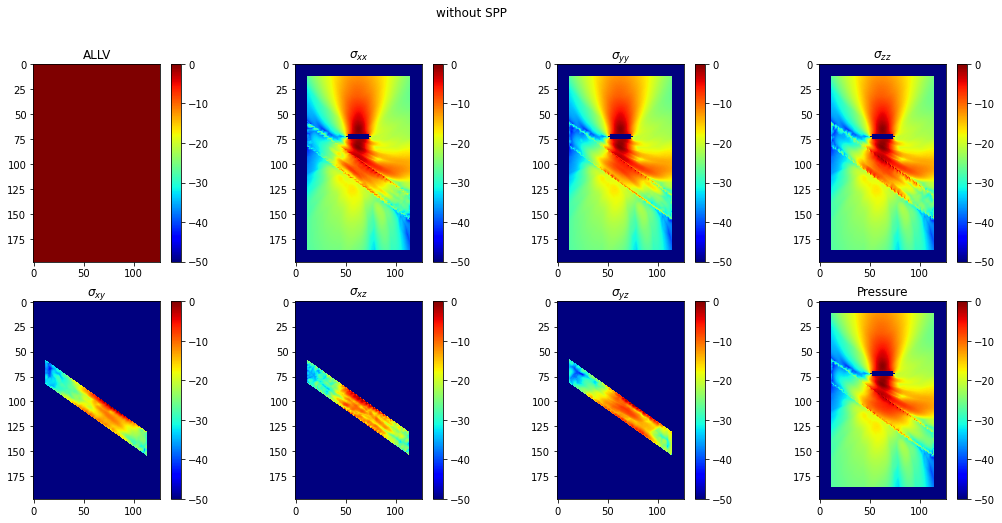

In [25]:
plt.figure(figsize=(18,8))
n=1
for k,RMSValue in DictRMSValueSPP.items():
    for a in range(3):
        for m in range(-2,3):
            RMSValue[np.roll(SourceMap>0,m,axis=a)]=0. #we turn off the values close the source 
    ax=plt.subplot(2,4,n)
    selP=RMSValue[:,int(N2/2),:].copy()
    if 'Sigma' in k:
        selP=selP/1e5 
    selP[selP==0]=1e-6;
    selP=20*np.log10(selP/selP.max())
    plt.imshow(selP.T,cmap=plt.cm.jet,vmin=-50)
    plt.colorbar()
    ax.set_aspect(1)
    if 'Sigma' in k:
        plt.title('$\sigma_{'+k.split('Sigma')[1]+'}$')
    else:
        plt.title(k)
    n+=1
plt.suptitle('with SPP')
plt.figure(figsize=(18,8))
n=1
for k,RMSValue in DictRMSValue.items():
    for a in range(3):
        for m in range(-2,3):
            RMSValue[np.roll(SourceMap>0,m,axis=a)]=0. #we turn off the values close the source 
    ax=plt.subplot(2,4,n)
    selP=RMSValue[:,int(N2/2),:].copy()
    if 'Sigma' in k:
        selP=selP/1e5 
    selP[selP==0]=1e-6;
    selP=20*np.log10(selP/selP.max())
    plt.imshow(selP.T,cmap=plt.cm.jet,vmin=-50)
    plt.colorbar()
    ax.set_aspect(1)
    if 'Sigma' in k:
        plt.title('$\sigma_{'+k.split('Sigma')[1]+'}$')
    else:
        plt.title(k)
    n+=1
plt.suptitle('without SPP');


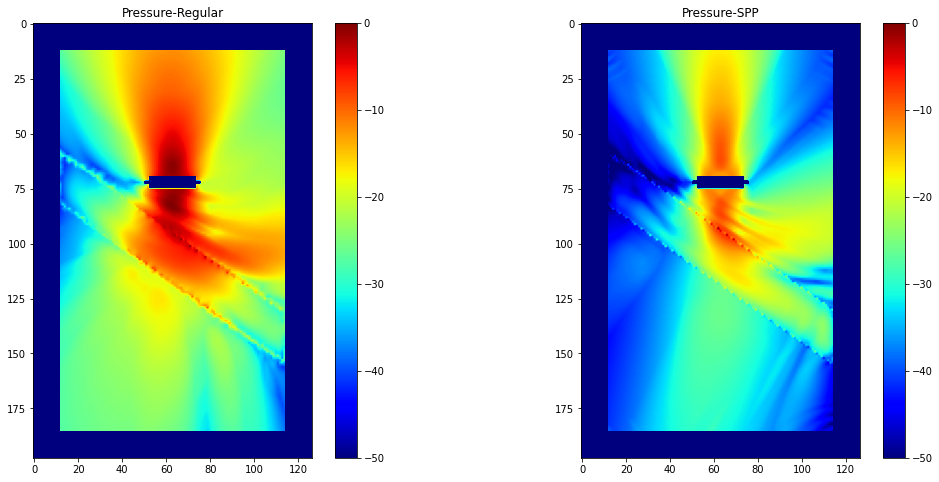

In [26]:
k='Pressure'
l=['-Regular','-SPP']
plt.figure(figsize=(18,8))
for n,RMSValue in enumerate([DictRMSValue[k],DictRMSValueSPP[k]]):
    for a in range(3):
        for m in range(-2,3):
            RMSValue[np.roll(SourceMap>0,m,axis=a)]=0. #we turn off the values close the source 
    ax=plt.subplot(1,2,n+1)
    selP=RMSValue[:,int(N2/2),:].copy()
    selP[selP==0]=1e-6;
    selP=20*np.log10(selP/selP.max())
    selP[np.isinf(selP)]=np.nanmin(selP)
    plt.imshow(selP.T,cmap=plt.cm.jet,vmin=-50)
    plt.colorbar()
    ax.set_aspect(1)
    plt.title(k+l[n])

We can observe the pattern inside the solid of the regular simulation (left) having more energy "trapped" inside the solid. If we plot the relative difference we can see better this artifact along with the difference in the reflected and transmitted patterns. The transmitted pressure field with the SPP method produces a *cleaner* transmitted field. Also, we can appreciate the erroenous reflected pattern distort signifcantly even the field in the upper region of water; the SPP version can show the upper pattern of the source that is expected for a flat source.

/var/folders/5s/12dkrmtj48df4qxdb694k5g00000gn/T/ipykernel_22476/1288486958.py:1: RuntimeWarning: invalid value encountered in divide
  Diff=((DictRMSValue[k]-DictRMSValueSPP[k])/DictRMSValueSPP[k])*100


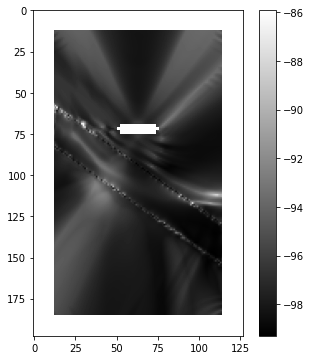

In [24]:
Diff=((DictRMSValue[k]-DictRMSValueSPP[k])/DictRMSValueSPP[k])*100
selP=Diff[:,int(N2/2),:].copy()
plt.figure(figsize=(6,6))
plt.imshow(selP.T,cmap=plt.cm.gray)
plt.colorbar()

The difference between both fields are signficant.

## Method 2 - run simulations separately and do averaging once done
The method 1 has the limitation of needing `SPP_ZONES`-times memory in the GPU to fit all the simulation domain. An alternative is to run simulations seperately and combine the sensor data.

The advantage is that we can increase significantly `SPP_ZONES` to increase the precision of the simulation with no extra GPU memory requirements. The disavantage is that we rely on the sensor data capture, which may also be prohibitive memory wise to collect for the whole domain. However, this approach may be sufficient for many scenarios where the simualtion domain is quite large.

For this approach, we just need to indicate `SPP_ZONES=1` and indicate the modified fraction of solid region in `SPP_VolumeFraction`

In [20]:
TotalZones=20
for N in range(TotalZones):
    ManualFraction=(GMap>(N/20))*1.0 # we will run for each of threshold values one by one
    SensorZone,LastMapZone,DictRMSValueZone,InputParam=PModel.StaggeredFDTD_3D_with_relaxation(
                                                         MaterialMap,
                                                         MaterialList,
                                                         Frequency,
                                                         SourceMap,
                                                         PulseSource,
                                                         SpatialStep,
                                                         TimeSimulation,
                                                         SensorMap,
                                                         Ox=Ox,
                                                         Oy=Oy,
                                                         Oz=Oz,                                                         
                                                         NDelta=PMLThickness,
                                                         ReflectionLimit=ReflectionLimit,
                                                         COMPUTING_BACKEND=COMPUTING_BACKEND,
                                                         USE_SINGLE=True,
                                                         SelRMSorPeak=1,
                                                         DT=TemporalStep,
                                                         SelMapsRMSPeakList=['ALLV','Sigmaxx',
                                                                            'Sigmayy','Sigmazz',
                                                                            'Sigmaxy','Sigmaxz',
                                                                            'Sigmayz','Pressure'],
                                                         DefaultGPUDeviceName=DefaultGPUDeviceName,
                                                         SelMapsSensorsList=['Vx','Vy','Vz',
                                                                            'Sigmaxx',
                                                                            'Sigmayy','Sigmazz',
                                                                            'Sigmaxy','Sigmaxz',
                                                                            'Sigmayz','Pressure'],
                                                         SensorSubSampling=1,# we need to keep complete sampling for the sensors to mimic the GPU-based SPP 
                                                         TypeSource=0,
                                                         SPP_ZONES=1, # we run with 1 zone and with the partial zone
                                                         SPP_VolumeFraction=ManualFraction, 
                                                         SILENT=1)
    #we only need to track the sensors
    if N==0:
        AccumZone=SensorZone 
    else:
        for k in AccumZone:
            if k != 'time':
                AccumZone[k]+=SensorZone[k]

for k in AccumZone:
    if k != 'time':
        AccumZone[k]/=TotalZones
            
clear_output(wait=True) #little function to clear a bit the excess of printing
print('DONE!')


DONE!


underflow encountered in square
underflow encountered in square


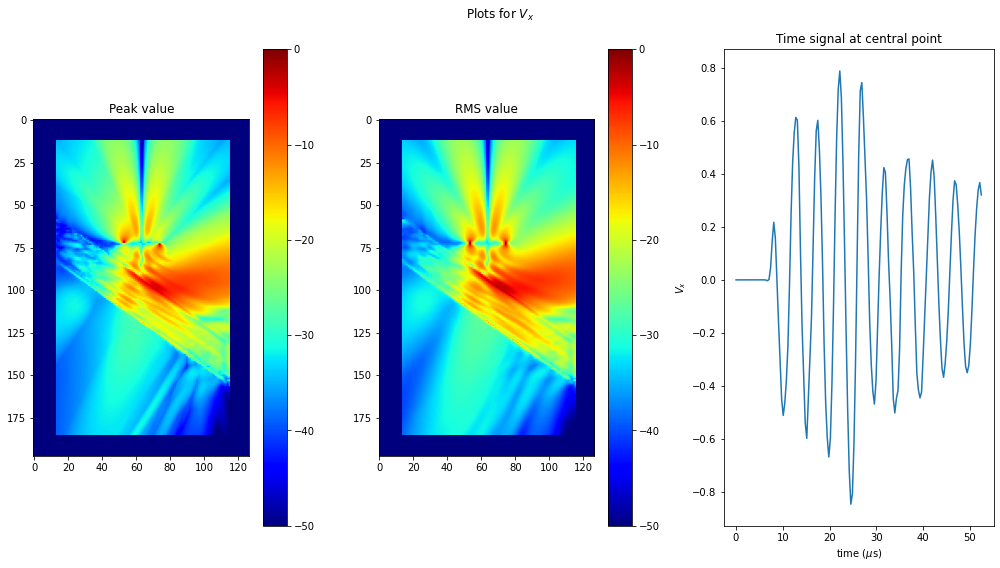

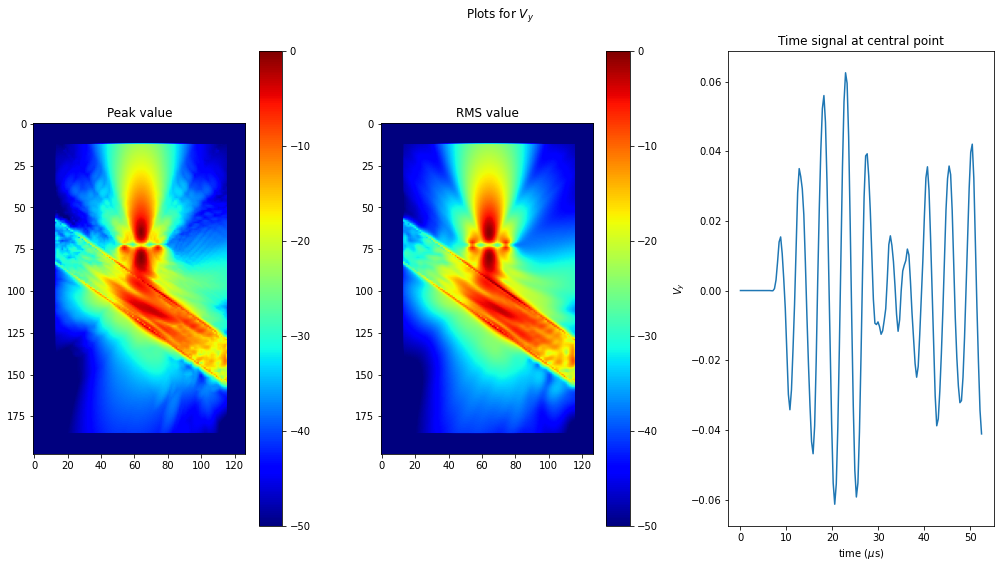

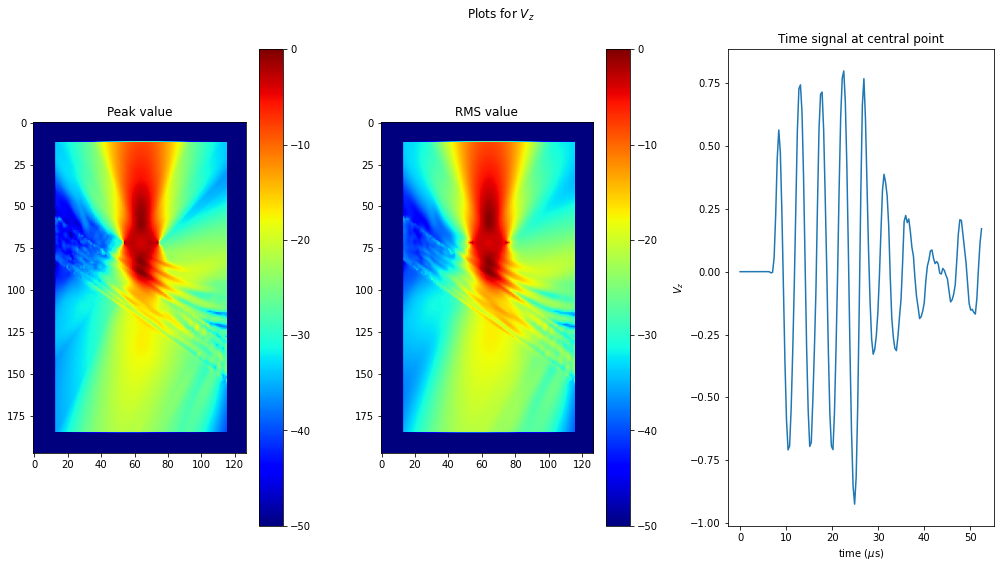

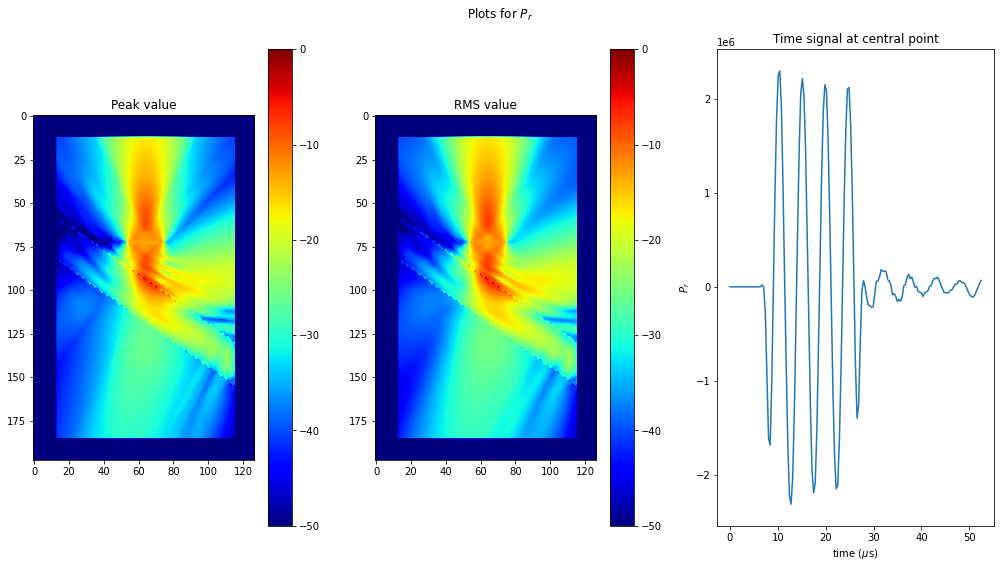

In [21]:
#To remain compatible with Matlab (whcih uses a Fortran convention for arrays, the index need to be rebuilt)
MaxSensorPlane=np.zeros((N1,N3))
RMSSensorPlane=np.zeros((N1,N3))
ALLVTime={}
for s in ['Vx','Vy','Vz','Pressure']:
    ALLVTime[s]=np.zeros((N1,N3,AccumZone['Vx'].shape[1]))
    #We use the IndexSensorMap array that was used in the low level function to 
    for n, index in enumerate( InputParam['IndexSensorMap']): 
        k=int(index/(N1*N2))
        j=int(index%(N1*N2))
        i=int(j%N1)
        j=int(j/N1)
        assert(j==int(N2/2)) #all way up we specified the XZ plane at N2/2, this assert should pass
        if i==int(N1/2) and k==int(N3/2):
            CentralPoint=n #we save this to later plot the time signal at the center
        MaxSensorPlane[i,k]=np.max(AccumZone[s][n,:])
        RMSSensorPlane[i,k]=np.sqrt(1./len(AccumZone[s][n,:])*np.sum(AccumZone[s][n,:]**2))
        ALLVTime[s][i,k,:]+=AccumZone[s][n,:]**2
    
    MaxSensorPlane[MaxSensorPlane<=0.0]=1e-6
    RMSSensorPlane[RMSSensorPlane<=0.0]=1e-6
    
    MaxSensorPlane=20*np.log10(MaxSensorPlane/MaxSensorPlane.max())
    RMSSensorPlane=20*np.log10(RMSSensorPlane/RMSSensorPlane.max())
    plt.figure(figsize=(14,8))
    plt.subplot(1,3,1)
    plt.imshow(MaxSensorPlane.T,cmap=plt.cm.jet,vmin=-50)
    plt.title('Peak value')
    plt.colorbar()
    plt.subplot(1,3,2)
    plt.imshow(RMSSensorPlane.T,cmap=plt.cm.jet,vmin=-50)
    plt.title('RMS value')
    plt.colorbar()
    plt.subplot(1,3,3)
    plt.plot(Sensor['time']*1e6,Sensor[s][CentralPoint])
    plt.xlabel('time ($\mu$s)')
    plt.ylabel('$'+s[0]+'_'+s[1]+'$')
    plt.title('Time signal at central point')
    plt.suptitle('Plots for $'+s[0]+'_'+s[1]+'$')
    plt.tight_layout()

Finally, we will reconstruct the same RMS map calculated from the method 1 for the amplitude of the pressure.

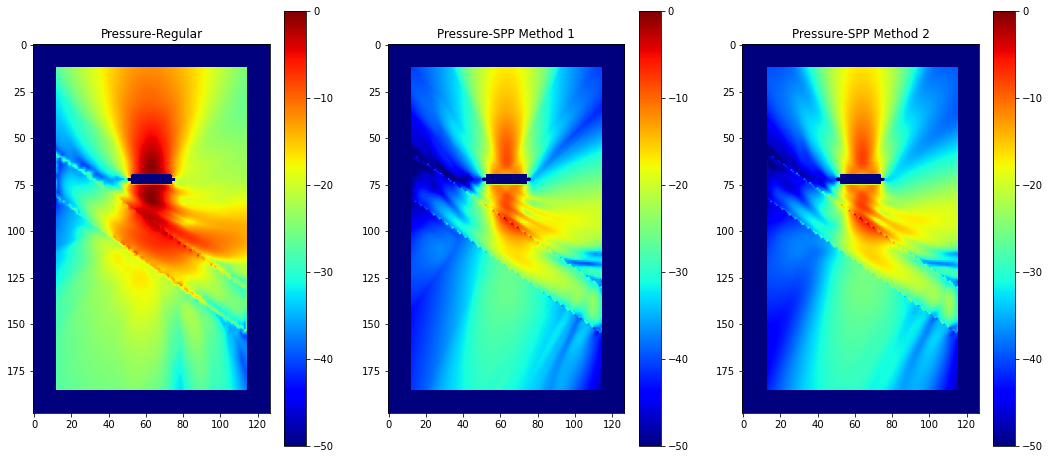

In [22]:
ALLV=np.zeros((N1,N3))
for k in ALLVTime:
    ALLV+=ALLVTime[k].sum(axis=2)
ALLV=np.sqrt(ALLV/ALLVTime['Vx'].shape[2])
k='Pressure'
l=['-Regular','-SPP Method 1','-SPP Method 2']
plt.figure(figsize=(18,8))
for n,RMSValue in enumerate([DictRMSValue[k],DictRMSValueSPP[k],ALLV]):
    ax=plt.subplot(1,3,n+1)
    if n<2:
        selP=RMSValue[:,int(N2/2),:].copy()
    else:
        selP=RMSValue.copy()
        for a in range(2):
            for m in range(-2,3):
                selP[np.roll(SourceMap[:,int(N2/2),:]>0,m,axis=a)]=0.
    selP[selP==0]=1e-6;
    selP=20*np.log10(selP/selP.max())
    plt.imshow(selP.T,cmap=plt.cm.jet,vmin=-50)
    plt.colorbar()
    ax.set_aspect(1)
    plt.title(k+l[n])